In [9]:
import s3fs
import pandas as pd

path = "IHS/ship_data.csv"
bucket = "projet-hackathon-un-2022"

fs = s3fs.S3FileSystem(
  client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'}
)

ship_data = pd.read_csv(fs.open(f'{bucket}/{path}',
                         mode='rb'))
ship_codes = pd.read_csv(fs.open(f'{bucket}/{path}'.replace("data","codes"),
                         mode='rb')
                 )

In [10]:
ship_codes.head(2)

,StatCode5,ShipTypeLevel1,ShipTypeLevel2,ShipTypeLevel3,ShipTypeLevel4,ShipTypeLevel5,SubGroup,SubType
0,A11A2TN,Cargo Carrying,Tankers,Liquefied Gas,LNG Tanker,LNG Tanker,Petroleum Products,LNG Tanker
1,A11A2TQ,Cargo Carrying,Tankers,Liquefied Gas,LNG Tanker,CNG Tanker,Petroleum Products,CNG Tanker


In [11]:
ship_data.head(2)

,StatCode5,MaritimeMobileServiceIdentityMMSINumber,ShipStatusEffectiveDate,ShiptypeLevel5,LRIMOShipNo,FuelConsumptionTotal,GrossTonnage,NetTonnage
0,X11A2YP,NaN,19610000,Yacht,1000019,0.0,551,165
1,X11A2YP,NaN,19951000,Yacht,1000021,0.0,1980,588


In [90]:
ship_data_enriched = ship_data.merge(ship_codes, on = "StatCode5")
ship_data_enriched.value_counts('ShipTypeLevel1', normalize = True)

ShipTypeLevel1
Cargo Carrying                 0.508045
Work Vessel                    0.419286
Non Merchant                   0.037187
Non Seagoing Merchant Ships    0.014563
Non Propelled                  0.012390
Non Ship Structure             0.008528
dtype: float64

In [54]:
AIS = pd.read_parquet(fs.open(f'{bucket}/AIS/ais_azov_20220101_20220107.parquet',
                         mode='rb'))

In [ ]:
import geopandas as gpd
import contextily as ctx

AIS_sample = AIS.loc[AIS['mmsi'] == 272168100]
example = gpd.GeoDataFrame(
    AIS_sample,
    geometry = gpd.points_from_xy(AIS_sample.longitude, AIS_sample.latitude),
    crs = 4326
)

ax = example.plot()
ctx.add_basemap(ax, source = ctx.providers.Stamen.Watercolor, crs = 4326)
ax.set_axis_off()

In [81]:
import folium

center = AIS_sample[['latitude', 'longitude']].mean().values.tolist()
sw = AIS_sample[['latitude', 'longitude']].min().values.tolist()
ne = AIS_sample[['latitude', 'longitude']].max().values.tolist()

m = folium.Map(location = center, tiles='Stamen Toner')
    
for i in range(0,len(AIS_sample)):
    folium.Marker([AIS_sample.iloc[i]['latitude'], AIS_sample.iloc[i]['longitude']]).add_to(m)

#m

In [91]:
#(ship_data_enriched['FuelConsumptionTotal'] != 0).mean()
ship_data_enriched.sample(3)

,StatCode5,MaritimeMobileServiceIdentityMMSINumber,ShipStatusEffectiveDate,ShiptypeLevel5,LRIMOShipNo,FuelConsumptionTotal,GrossTonnage,NetTonnage,ShipTypeLevel1,ShipTypeLevel2,ShipTypeLevel3,ShipTypeLevel4,ShipTypeLevel5,SubGroup,SubType
32578,B11B2FV,525700898.0,19931211,Fishing Vessel,8547236,0.0,125,52,Work Vessel,Fishing,Fish Catching,Fishing Vessel,Fishing Vessel,Fishing,Fishing Vessel
127516,A13B2TP,NaN,20111230,Products Tanker,7383360,41.5,17679,9781,Cargo Carrying,Tankers,Oil,Oil Products Tanker,Products Tanker,Petroleum Products,Products Tanker
162419,A36A2PR,431005219.0,20210130,Passenger/Ro-Ro Ship (Vehicles),9666699,0.0,5380,0,Cargo Carrying,Dry Cargo/Passenger,Passenger/Ro-Ro Cargo,Passenger/Ro-Ro Cargo Ship,Passenger/Ro-Ro Ship (Vehicles),Passenger,Passenger/Ro-Ro Ship (Vehicles)


In [86]:
AIS.head(2)

,hex_resolution,longitude,mmsi,eeid,H3_int_index_8,latitude,dt_insert_utc,polygon_name
0,8,33.333333,272168100,5281533799698068644,613022282759012351,46.758333,2022-01-01 23:53:28,Polygon
1,8,32.910907,272686000,4861284512643996592,613022403708059647,46.107775,2022-01-01 21:25:23,Polygon


# Nombre de bateaux

In [94]:
AIS_enriched = AIS.merge(
    ship_data_enriched,left_on = 'mmsi',
    right_on = "MaritimeMobileServiceIdentityMMSINumber")

In [109]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [124]:
AIS_enriched.drop_duplicates(subset = "mmsi").value_counts("ShipTypeLevel1")
#AIS_enriched.filter(like='ShipTypeLevel').apply(pd.Series.value_counts, axis = 0)
AIS_enriched.drop_duplicates(subset = "mmsi").value_counts("ShipTypeLevel1")

ShipTypeLevel1
Cargo Carrying                 394
Work Vessel                     88
Non Seagoing Merchant Ships      4
Non Propelled                    1
dtype: int64

In [125]:
AIS_enriched.drop_duplicates(subset = "mmsi").value_counts("ShipTypeLevel2")

ShipTypeLevel2
Dry Cargo/Passenger            262
Tankers                         91
Miscellaneous                   82
Bulk Carriers                   41
Non-Seagoing Merchant Ships      4
Fishing                          3
Offshore                         3
Non-Propelled                    1
dtype: int64

In [126]:
AIS_enriched.drop_duplicates(subset = "mmsi").value_counts("ShipTypeLevel3")

ShipTypeLevel3
General Cargo            257
Towing / Pushing          57
Oil                       52
Chemical                  35
Bulk Dry                  35
Other Activities          17
Dredging                   7
Bulk Dry / Oil             6
Liquefied Gas              4
Fish Catching              2
Offshore Supply            2
Container                  2
Other Non-Seagoing         2
Passenger/Ro-Ro Cargo      2
Tanker                     2
Other Fishing              1
Other Offshore             1
Other activities           1
Ro-Ro Cargo                1
Barge                      1
dtype: int64

In [127]:
AIS_enriched.drop_duplicates(subset = "mmsi").value_counts("ShipTypeLevel4")

ShipTypeLevel4
General Cargo Ship                   257
Tug                                   46
Oil Products Tanker                   44
Bulk Carrier                          35
Chemical/Oil Products Tanker          34
Pusher Tug                            11
Crude Oil Tanker                       8
Hopper Dredger                         6
Ore/Oil Carrier                        6
Crane Ship                             5
Motor Hopper                           4
LPG Tanker                             4
Pollution Control Vessel               4
Pilot Vessel                           2
Passenger/Ro-Ro Cargo Ship             2
Container Ship                         2
Icebreaker                             2
Fishing Vessel                         2
Inland Waterways Other Activities      2
Bunkering Tanker                       1
Inland Waterways Oil Tanker            1
Non Propelled Barge                    1
Offshore Tug/Supply Ship               1
Chemical Tanker                        1
I

## Comparaison à la base générale des bateaux

Etudes des bateaux dans cette région par rapport aux bateaux en circulation dans le monde.
Bateaux médian dans AIS plus gros mais beaucoup moins de gros bateaux (probablement les tankers). 

In [169]:
import plotly.express as px

## Secteur

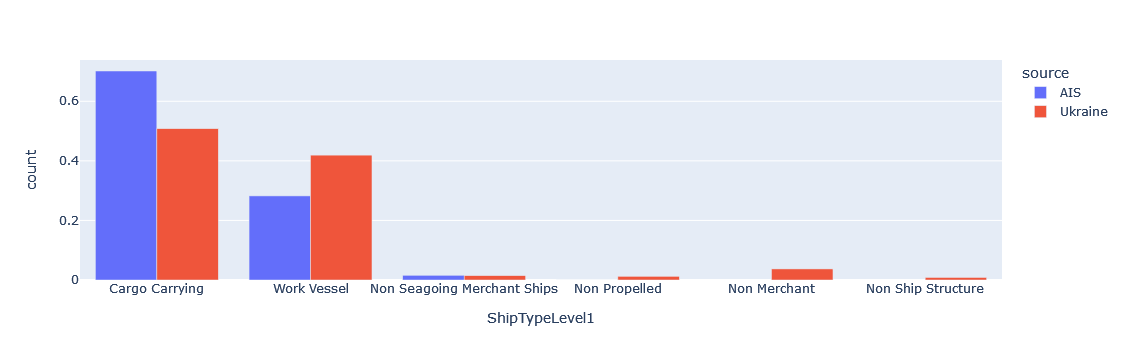

In [171]:
x = AIS_enriched.value_counts("ShipTypeLevel1", normalize = True)
y = ship_data_enriched.value_counts("ShipTypeLevel1", normalize = True)


temp = pd.concat(
    [x.reset_index().assign(source="AIS"),
     y.reset_index().assign(source="Ukraine")]
)
temp = temp.rename({0: "count"}, axis = 1)

fig = px.bar(temp, x='ShipTypeLevel1', y='count', color = "source", barmode='group')
fig.show()

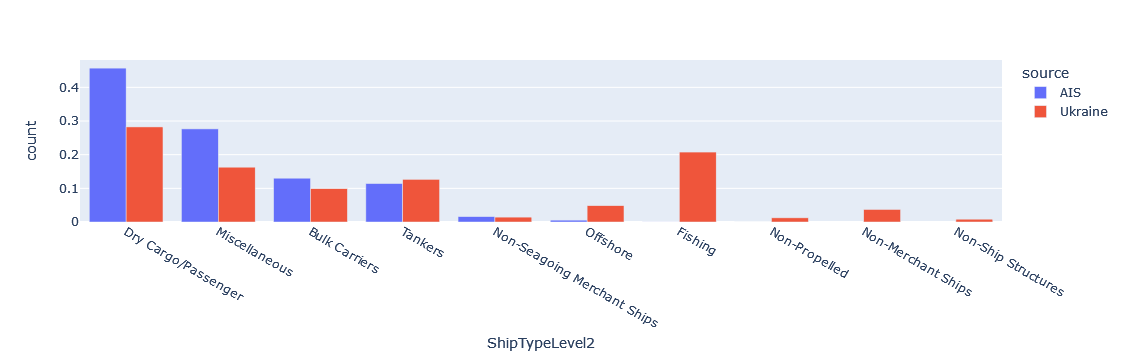

In [172]:
x = AIS_enriched.value_counts("ShipTypeLevel2", normalize = True)
y = ship_data_enriched.value_counts("ShipTypeLevel2", normalize = True)


temp = pd.concat(
    [x.reset_index().assign(source="AIS"),
     y.reset_index().assign(source="Ukraine")]
)
temp = temp.rename({0: "count"}, axis = 1)

fig = px.bar(temp, x='ShipTypeLevel2', y='count', color = "source", barmode='group')
fig.show()

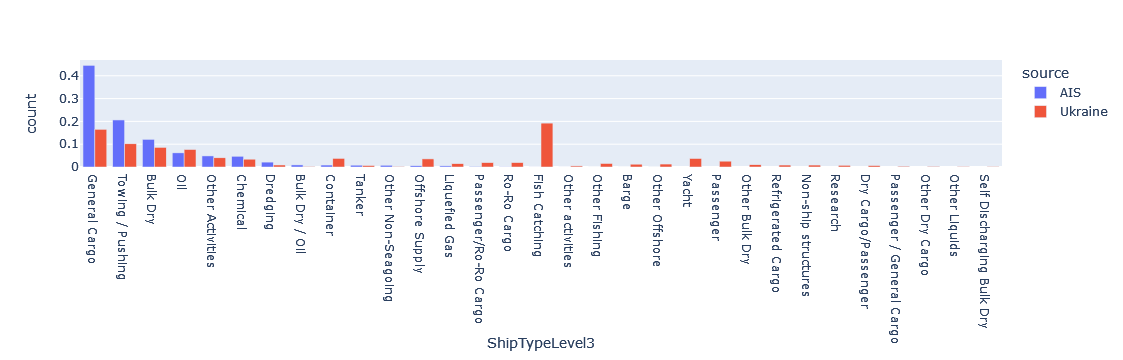

In [174]:
x = AIS_enriched.value_counts("ShipTypeLevel3", normalize = True)
y = ship_data_enriched.value_counts("ShipTypeLevel3", normalize = True)


temp = pd.concat(
    [x.reset_index().assign(source="AIS"),
     y.reset_index().assign(source="Ukraine")]
)
temp = temp.rename({0: "count"}, axis = 1)

fig = px.bar(temp, x='ShipTypeLevel3', y='count', color = "source", barmode='group')
fig.show()

## Tonnage

In [132]:
AIS_enriched['GrossTonnage'].describe().reset_index().merge(
    ship_data_enriched['GrossTonnage'].describe().reset_index(),
    on = "index")

,index,GrossTonnage_x,GrossTonnage_y
0,count,120028.000000,246724.000000
1,mean,7566.910804,10824.313930
2,std,14524.910267,25176.081685
3,min,80.000000,0.000000
4,25%,997.000000,207.000000
5,50%,2802.000000,773.000000
6,75%,5684.000000,7913.000000
7,max,91205.000000,499167.000000


<AxesSubplot: xlabel='GrossTonnage', ylabel='Count'>

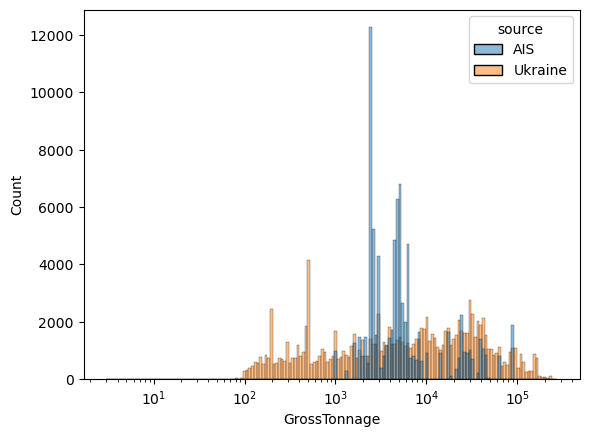

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

x = AIS_enriched.loc[AIS_enriched['ShipTypeLevel1'] == "Cargo Carrying"]#['GrossTonnage']
y = ship_data_enriched.loc[ship_data_enriched['ShipTypeLevel1'] == "Cargo Carrying"]#['GrossTonnage']

temp = pd.concat(
    [x.assign(source="AIS"),y.assign(source="Ukraine")]
)
temp = temp.loc[temp['GrossTonnage'] > 0]

sns.histplot(data=temp, x = "GrossTonnage", hue = "source", log_scale=True)